## 轉換資料型態

In [1]:
import pandas as pd
from opencc import OpenCC

def convert_news_to_csv(data_path, csv_file_path):
    cc = OpenCC('s2tw') # 簡體轉繁體
    with open(data_path, 'r', encoding = "utf-8") as f:
        lines = f.read().split('\n')
        english, chinese = [], []
        for line in lines:
            if line:
                en, cn, _, = line.split('\t') # 資料是\t分割的
                english.append(en)
                
                chinese.append(cc.convert(cn))
    df = pd.DataFrame({'chinese':chinese, 'english':english})
    df.to_csv(csv_file_path)
    
convert_news_to_csv('cmn.txt', 'translate.csv')

'import pandas as pd\nfrom opencc import OpenCC\n\ndef convert_news_to_csv(data_path, csv_file_path):\n    cc = OpenCC(\'s2tw\') # 簡體轉繁體\n    with open(data_path, \'r\', encoding = "utf-8") as f:\n        lines = f.read().split(\'\n\')\n        english, chinese = [], []\n        for line in lines:\n            if line:\n                en, cn, _, = line.split(\'\t\') # 資料是\t分割的\n                english.append(en)\n                \n                chinese.append(cc.convert(cn))\n    df = pd.DataFrame({\'chinese\':chinese, \'english\':english})\n    df.to_csv(csv_file_path)\n    \nconvert_news_to_csv(\'cmn.txt\', \'translate.csv\')'

# 固定亂數

In [1]:
import torch
import numpy as np
import random

def set_seeds(seed):
    random.seed(seed)  # 設定 Python 標準庫的亂數生成器種子
    np.random.seed(seed)  # 設定 NumPy 亂數生成器種子
    torch.manual_seed(seed)  # 設定 PyTorch 的 CPU 亂數生成器種子
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)  # 設定 PyTorch 在單個 GPU 上的亂數種子
        torch.cuda.manual_seed_all(seed)  # 設定 PyTorch 在所有 GPU 上的亂數種子
    torch.backends.cudnn.benchmark = False  # 禁用 cuDNN 的基準測試功能
    torch.backends.cudnn.deterministic = True  # 強制 cuDNN 使用確定性算法

set_seeds(2526)

## 重新讀取CSV檔案

In [2]:
import pandas as pd
df = pd.read_csv('translate.csv')
input_texts = df['chinese'].values
target_texts = df['english'].values

# 讀取中英文Tokenizer

In [3]:
from transformers import AutoTokenizer
def process_texts(tokenizer, texts):
    ids = tokenizer(texts[20]).input_ids
    return tokenizer.decode(ids)

src_tokenizer = AutoTokenizer.from_pretrained('bert-base-chinese')
tgt_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

cn_text = process_texts(src_tokenizer, input_texts)
en_text = process_texts(tgt_tokenizer, target_texts)

print('中文轉換後的結果:',cn_text,'\n英文轉換後的結果:', en_text)

中文轉換後的結果: [CLS] 我 沒 事 。 [SEP] 
英文轉換後的結果: [CLS] i'm ok. [SEP]


## 建立Pytorch Dataloader

In [4]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class TranslateDataset(Dataset):
    def __init__(self, x, y, src_tokenizer, tgt_tokenizer):
        self.x = x
        self.y = y
        self.src_tokenizer = src_tokenizer
        self.tgt_tokenizer = tgt_tokenizer

    def __getitem__(self, index):
        return self.x[index], self.y[index]
       
    def __len__(self):
        return len(self.x)
    
    def collate_fn(self, batch):    
        batch_x, batch_y = zip(*batch)
        inputs = self.src_tokenizer(batch_x, max_length=256, truncation=True, padding="longest", return_tensors='pt').input_ids[:, 1:]
        targets = self.tgt_tokenizer(batch_y, max_length=256, truncation=True, padding="longest", return_tensors='pt').input_ids
       
        return {'src_input_ids':inputs, 'tgt_input_ids': targets}

        
x_train, x_valid, y_train, y_valid = train_test_split(input_texts, target_texts, train_size=0.8, random_state=46, shuffle=True)

trainset = TranslateDataset(x_train, y_train, src_tokenizer, tgt_tokenizer)
validset = TranslateDataset(x_valid, y_valid, src_tokenizer, tgt_tokenizer)

train_loader = DataLoader(trainset, batch_size = 64, shuffle = True, num_workers = 0, pin_memory = True, collate_fn=trainset.collate_fn)
valid_loader = DataLoader(validset, batch_size = 64, shuffle = True, num_workers = 0, pin_memory = True, collate_fn=validset.collate_fn)

## 建立Encoder模型

In [5]:
import torch.nn as nn

class EncoderGRU(nn.Module):
    def __init__(self, vocab_size, hidden_size, padding_idx):
        super(EncoderGRU, self).__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_size, padding_idx=padding_idx)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(0.1)

    def forward(self, token_ids):
        embedded = self.dropout(self.embedding(token_ids))
        #embedded: (batch_size, time_step, emb_dim)
        output, hidden = self.gru(embedded) 
        # output: (batch_size, time_step, hidden_size * 2)
        # hidden: (2, batch_size, hidden_size)
        return output, hidden


In [6]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.encoder_projection = nn.Linear(hidden_size, hidden_size)
        self.decoder_projection = nn.Linear(hidden_size, hidden_size)
        self.attention_v = nn.Linear(hidden_size, 1)
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, encoder_hidden, decoder_hidden):
        energy = self.tanh(self.encoder_projection(encoder_hidden) + self.decoder_projection(decoder_hidden)) #公式5.5
        #energy: (batch_size, time_step, hidden_size)
        scores = self.attention_v(energy) # 公式5.6
        #scores: (batch_size, time_step, 1)
        scores = scores.squeeze(2).unsqueeze(1)
        #scores: (batch_size, 1, time_step)

        attention_weights = self.softmax(scores) # 公式5.7
        # attention_weights (batch_size, 1, time_step)
        context_vector = torch.bmm(attention_weights, decoder_hidden) # 公式5.8
        #context_vector: (batch_size, 1, hidden_size)
        return context_vector


In [7]:
class DecoderGRU(nn.Module):
    def __init__(self, attention, hidden_size, output_size, padding_idx):
        super(DecoderGRU, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size, padding_idx=padding_idx)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.output_projection = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.attention = attention


    def forward(self, encoder_outputs, decoder_hidden, decoder_input_ids):
        # decoder_input_ids: (batch_size, 1)
        embedded = self.dropout(self.embedding(decoder_input_ids)) 
        # embedded: (1, batch_size, emb_dim)
        decoder_state = decoder_hidden.permute(1, 0, 2) 
        #decoder_state (batch_size, 1, emb_dim)
        context = self.attention(decoder_state, encoder_outputs) 
        # (batch_size, 1, hidden_size)
        input_gru = torch.cat((embedded, context), dim=-1) 
        # input_gru (batch_size, 1, hidden_size + emb_dim)
        output, decoder_hidden = self.gru(input_gru, decoder_hidden) 
        # output: (batch_size, time_step, hidden_size)
        # decoder_hidden: (1, batch_size, hidden_size)
        decoder_output = self.output_projection(output)
        # decoder_output: (batch_size, 1, output_size)
        return decoder_output, decoder_hidden


In [8]:
class Attentionseq2seq(nn.Module):
    def __init__(self, encoder, decoder, padding_idx):
        super(Attentionseq2seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.criterion = nn.NLLLoss(ignore_index=padding_idx)
        self.logsoftmax = nn.LogSoftmax(dim=-1)

    def forward(self, **kwargs):
        input_ids = kwargs['src_input_ids']
        targets = kwargs['tgt_input_ids']

        # Encoder
        encoder_outputs, decoder_hidden = self.encoder(input_ids)
        # encoder_outputs: (batch_size, time_step, hidden_size)
        # decoder_hidden: (1, batch_size, hidden_size)
        decoder_next_input = torch.empty(targets.shape[0], 1, dtype=torch.long).fill_(101).to(input_ids.device.type) # 加入CLS token
        # decoder_next_input: (batch_size, 1)

        # Decoder
        decoder_outputs = []
        for i in range(targets.shape[1]):
            decoder_next_input, decoder_hidden = self.decoder(encoder_outputs, decoder_hidden, decoder_next_input)
            # decoder_next_input: (batch_size, 1, hidden_size)
            # decoder_hidden: (1, batch_size, hidden_size)

            decoder_outputs.append(decoder_next_input)      # 儲存當前時序的文字分布狀態
            decoder_next_input = targets[:, i].unsqueeze(1) # 取出下一個對應的文字進行生成
            # decoder_next_input: (batch_size, 1)

        decoder_outputs = torch.cat(decoder_outputs, dim=1) # 完整的Decoder隱狀態輸出
        # decoder_outputs: (batch_size, time_step, output_dim)
        decoder_outputs = self.logsoftmax(decoder_outputs)  # 計算個文字機率
        # decoder_outputs: (batch_size, time_step, output_dim)
       
        # 計算損失值
        loss = self.criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)), # (batch_size * time_step,  output_dim)
            targets.view(-1) # (batch_size * time_step)
        )
        
        return loss, decoder_outputs


    def generate(self, input_ids, sos_token=101, eos_token=102, max_len=50):
        with torch.no_grad():
            encoder_outputs, decoder_hidden = self.encoder(input_ids)
            decoder_outputs = []
            decoder_next_input = torch.empty(1, 1, dtype=torch.long).fill_(sos_token).to(input_ids.device.type)
            for _ in range(max_len):
                decoder_next_input, decoder_hidden = self.decoder(encoder_outputs, decoder_hidden, decoder_next_input)
                decoder_outputs.append(decoder_next_input)

                _, top_token_index = decoder_next_input.topk(1)
                if top_token_index == eos_token:
                    break
                
                decoder_next_input = top_token_index.squeeze(-1).detach()  # detach from history as input
            decoder_outputs = torch.cat(decoder_outputs, dim=1)
            decoder_outputs = self.logsoftmax(decoder_outputs)

            _, generated_ids = decoder_outputs.topk(1)
        return generated_ids.squeeze()



Valid Epoch 0: 100%|██████████| 94/94 [00:02<00:00, 38.06it/s, loss=4.329]


Saving Model With Loss 3.74545
Train Loss: 4.51027| Valid Loss: 3.74545| Best Loss: 3.74545



Valid Epoch 1: 100%|██████████| 94/94 [00:02<00:00, 38.27it/s, loss=3.117]


Saving Model With Loss 3.29497
Train Loss: 3.44489| Valid Loss: 3.29497| Best Loss: 3.29497



Valid Epoch 2: 100%|██████████| 94/94 [00:02<00:00, 38.19it/s, loss=3.094]


Saving Model With Loss 3.00557
Train Loss: 3.02972| Valid Loss: 3.00557| Best Loss: 3.00557



Valid Epoch 3: 100%|██████████| 94/94 [00:02<00:00, 35.55it/s, loss=2.984]


Saving Model With Loss 2.79760
Train Loss: 2.72716| Valid Loss: 2.79760| Best Loss: 2.79760



Valid Epoch 4: 100%|██████████| 94/94 [00:02<00:00, 35.70it/s, loss=2.417]


Saving Model With Loss 2.62855
Train Loss: 2.48080| Valid Loss: 2.62855| Best Loss: 2.62855



Valid Epoch 5: 100%|██████████| 94/94 [00:02<00:00, 34.94it/s, loss=2.349]


Saving Model With Loss 2.49096
Train Loss: 2.26636| Valid Loss: 2.49096| Best Loss: 2.49096



Valid Epoch 6: 100%|██████████| 94/94 [00:02<00:00, 36.02it/s, loss=2.255]


Saving Model With Loss 2.38131
Train Loss: 2.07723| Valid Loss: 2.38131| Best Loss: 2.38131



Valid Epoch 7: 100%|██████████| 94/94 [00:01<00:00, 52.13it/s, loss=2.318]


Saving Model With Loss 2.28243
Train Loss: 1.90391| Valid Loss: 2.28243| Best Loss: 2.28243



Valid Epoch 8: 100%|██████████| 94/94 [00:01<00:00, 53.07it/s, loss=2.726]


Saving Model With Loss 2.20376
Train Loss: 1.74681| Valid Loss: 2.20376| Best Loss: 2.20376



Valid Epoch 9: 100%|██████████| 94/94 [00:01<00:00, 50.97it/s, loss=2.730]


Saving Model With Loss 2.13687
Train Loss: 1.60042| Valid Loss: 2.13687| Best Loss: 2.13687



Valid Epoch 10: 100%|██████████| 94/94 [00:01<00:00, 51.86it/s, loss=1.973]


Saving Model With Loss 2.07880
Train Loss: 1.46765| Valid Loss: 2.07880| Best Loss: 2.07880



Valid Epoch 11: 100%|██████████| 94/94 [00:01<00:00, 52.47it/s, loss=2.066]


Saving Model With Loss 2.03045
Train Loss: 1.34397| Valid Loss: 2.03045| Best Loss: 2.03045



Valid Epoch 12: 100%|██████████| 94/94 [00:01<00:00, 52.62it/s, loss=2.058]


Saving Model With Loss 1.98748
Train Loss: 1.22902| Valid Loss: 1.98748| Best Loss: 1.98748



Valid Epoch 13: 100%|██████████| 94/94 [00:01<00:00, 51.25it/s, loss=1.912]


Saving Model With Loss 1.95400
Train Loss: 1.12527| Valid Loss: 1.95400| Best Loss: 1.95400



Valid Epoch 14: 100%|██████████| 94/94 [00:02<00:00, 40.53it/s, loss=1.987]


Saving Model With Loss 1.94274
Train Loss: 1.02858| Valid Loss: 1.94274| Best Loss: 1.94274



Valid Epoch 15: 100%|██████████| 94/94 [00:02<00:00, 35.23it/s, loss=2.712]


Saving Model With Loss 1.91255
Train Loss: 0.94021| Valid Loss: 1.91255| Best Loss: 1.91255



Valid Epoch 16: 100%|██████████| 94/94 [00:02<00:00, 35.77it/s, loss=1.940]


Saving Model With Loss 1.88857
Train Loss: 0.85623| Valid Loss: 1.88857| Best Loss: 1.88857



Valid Epoch 17: 100%|██████████| 94/94 [00:02<00:00, 34.12it/s, loss=1.695]


Saving Model With Loss 1.87978
Train Loss: 0.78056| Valid Loss: 1.87978| Best Loss: 1.87978



Valid Epoch 18: 100%|██████████| 94/94 [00:02<00:00, 33.49it/s, loss=1.750]


Saving Model With Loss 1.87036
Train Loss: 0.71117| Valid Loss: 1.87036| Best Loss: 1.87036



Valid Epoch 19: 100%|██████████| 94/94 [00:01<00:00, 51.93it/s, loss=2.187]


Saving Model With Loss 1.86122
Train Loss: 0.64657| Valid Loss: 1.86122| Best Loss: 1.86122



Valid Epoch 20: 100%|██████████| 94/94 [00:01<00:00, 51.89it/s, loss=2.196]


Saving Model With Loss 1.85770
Train Loss: 0.58910| Valid Loss: 1.85770| Best Loss: 1.85770



Valid Epoch 21: 100%|██████████| 94/94 [00:01<00:00, 51.56it/s, loss=1.494]


Saving Model With Loss 1.84741
Train Loss: 0.53640| Valid Loss: 1.84741| Best Loss: 1.84741



Valid Epoch 22: 100%|██████████| 94/94 [00:01<00:00, 51.60it/s, loss=1.997]


Train Loss: 0.48615| Valid Loss: 1.85511| Best Loss: 1.84741



Valid Epoch 23: 100%|██████████| 94/94 [00:01<00:00, 48.66it/s, loss=2.367]


Train Loss: 0.44147| Valid Loss: 1.86302| Best Loss: 1.84741



Valid Epoch 24: 100%|██████████| 94/94 [00:02<00:00, 38.39it/s, loss=1.965]


------------------------------------
|Model can't improve, stop training|
------------------------------------


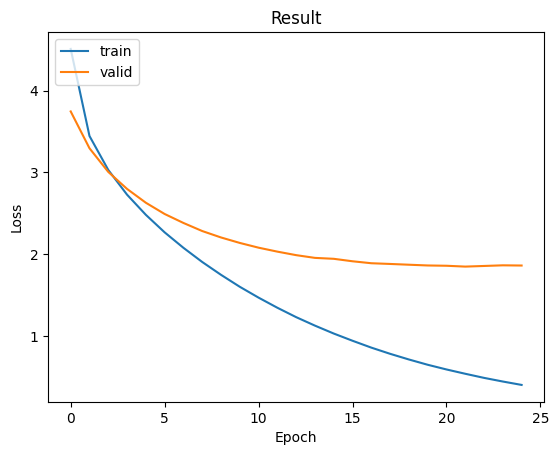

In [56]:
import torch.optim as optim
from trainer import Trainer

# 主程式部分
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
hidden_size = 768
encoder = EncoderGRU(
    vocab_size=len(src_tokenizer), 
    hidden_size=hidden_size, 
    padding_idx=src_tokenizer.pad_token_id
)

decoder = DecoderGRU(
    attention = BahdanauAttention(hidden_size=hidden_size),
    hidden_size=hidden_size, 
    output_size=len(tgt_tokenizer), 
    padding_idx=tgt_tokenizer.pad_token_id
)

model = Attentionseq2seq(
    encoder = encoder,
    decoder = decoder,
    padding_idx = tgt_tokenizer.pad_token_id
).to(device)

optimizer_e = optim.Adam(encoder.parameters(), lr=1e-4)
optimizer_d = optim.Adam(decoder.parameters(), lr=1e-4)
trainer = Trainer(
    epochs=30, 
    train_loader=train_loader, 
    valid_loader=valid_loader, 
    model=model, 
    optimizer=[optimizer_e, optimizer_d],
    early_stopping=3
)
trainer.train()

Valid Epoch 0: 100%|██████████| 94/94 [00:06<00:00, 15.03it/s, loss=3.722]


Saving Model With Loss 3.74700
Train Loss: 4.52063| Valid Loss: 3.74700| Best Loss: 3.74700



Valid Epoch 1: 100%|██████████| 94/94 [00:05<00:00, 15.75it/s, loss=3.117]


Saving Model With Loss 3.27308
Train Loss: 3.43460| Valid Loss: 3.27308| Best Loss: 3.27308



Valid Epoch 2: 100%|██████████| 94/94 [00:06<00:00, 15.31it/s, loss=2.748]


Saving Model With Loss 2.98093
Train Loss: 3.00892| Valid Loss: 2.98093| Best Loss: 2.98093



Valid Epoch 3: 100%|██████████| 94/94 [00:05<00:00, 15.70it/s, loss=2.835]


Saving Model With Loss 2.78210
Train Loss: 2.71017| Valid Loss: 2.78210| Best Loss: 2.78210



Valid Epoch 4: 100%|██████████| 94/94 [00:03<00:00, 24.05it/s, loss=2.886]


Saving Model With Loss 2.62037
Train Loss: 2.46968| Valid Loss: 2.62037| Best Loss: 2.62037



Valid Epoch 5: 100%|██████████| 94/94 [00:05<00:00, 15.71it/s, loss=2.238]


Saving Model With Loss 2.48475
Train Loss: 2.26083| Valid Loss: 2.48475| Best Loss: 2.48475



Valid Epoch 6: 100%|██████████| 94/94 [00:05<00:00, 15.68it/s, loss=2.281]


Saving Model With Loss 2.37273
Train Loss: 2.07325| Valid Loss: 2.37273| Best Loss: 2.37273



Valid Epoch 7: 100%|██████████| 94/94 [00:05<00:00, 15.73it/s, loss=2.408]


Saving Model With Loss 2.28417
Train Loss: 1.90297| Valid Loss: 2.28417| Best Loss: 2.28417



Valid Epoch 8: 100%|██████████| 94/94 [00:06<00:00, 15.12it/s, loss=2.248]


Saving Model With Loss 2.19568
Train Loss: 1.74620| Valid Loss: 2.19568| Best Loss: 2.19568



Valid Epoch 9: 100%|██████████| 94/94 [00:06<00:00, 15.63it/s, loss=2.119]


Saving Model With Loss 2.13571
Train Loss: 1.60216| Valid Loss: 2.13571| Best Loss: 2.13571



Valid Epoch 10: 100%|██████████| 94/94 [00:06<00:00, 15.47it/s, loss=2.329]


Saving Model With Loss 2.07435
Train Loss: 1.47939| Valid Loss: 2.07435| Best Loss: 2.07435



Valid Epoch 11: 100%|██████████| 94/94 [00:03<00:00, 23.85it/s, loss=1.954]


Saving Model With Loss 2.02481
Train Loss: 1.35044| Valid Loss: 2.02481| Best Loss: 2.02481



Valid Epoch 12: 100%|██████████| 94/94 [00:06<00:00, 14.18it/s, loss=1.682]


Saving Model With Loss 1.98595
Train Loss: 1.23838| Valid Loss: 1.98595| Best Loss: 1.98595



Valid Epoch 13: 100%|██████████| 94/94 [00:06<00:00, 14.56it/s, loss=1.906]


Saving Model With Loss 1.95188
Train Loss: 1.13462| Valid Loss: 1.95188| Best Loss: 1.95188



Valid Epoch 14: 100%|██████████| 94/94 [00:01<00:00, 51.46it/s, loss=1.729]


Saving Model With Loss 1.92407
Train Loss: 1.03890| Valid Loss: 1.92407| Best Loss: 1.92407



Valid Epoch 15: 100%|██████████| 94/94 [00:01<00:00, 48.81it/s, loss=1.645]


Saving Model With Loss 1.90080
Train Loss: 0.95091| Valid Loss: 1.90080| Best Loss: 1.90080



Valid Epoch 16: 100%|██████████| 94/94 [00:01<00:00, 48.77it/s, loss=2.182]


Saving Model With Loss 1.88469
Train Loss: 0.86965| Valid Loss: 1.88469| Best Loss: 1.88469



Valid Epoch 17: 100%|██████████| 94/94 [00:01<00:00, 50.49it/s, loss=2.286]


Saving Model With Loss 1.87546
Train Loss: 0.79307| Valid Loss: 1.87546| Best Loss: 1.87546



Valid Epoch 18: 100%|██████████| 94/94 [00:01<00:00, 49.50it/s, loss=2.437]


Saving Model With Loss 1.86824
Train Loss: 0.72407| Valid Loss: 1.86824| Best Loss: 1.86824



Valid Epoch 19: 100%|██████████| 94/94 [00:01<00:00, 51.74it/s, loss=1.860]


Saving Model With Loss 1.85165
Train Loss: 0.66012| Valid Loss: 1.85165| Best Loss: 1.85165



Valid Epoch 20: 100%|██████████| 94/94 [00:01<00:00, 47.40it/s, loss=1.971]


Train Loss: 0.59980| Valid Loss: 1.85573| Best Loss: 1.85165



Valid Epoch 21: 100%|██████████| 94/94 [00:01<00:00, 50.62it/s, loss=1.602]


Saving Model With Loss 1.84276
Train Loss: 0.54630| Valid Loss: 1.84276| Best Loss: 1.84276



Valid Epoch 22: 100%|██████████| 94/94 [00:01<00:00, 51.09it/s, loss=1.623]


Train Loss: 0.49671| Valid Loss: 1.84493| Best Loss: 1.84276



Valid Epoch 23: 100%|██████████| 94/94 [00:01<00:00, 47.11it/s, loss=2.167]


Train Loss: 0.45202| Valid Loss: 1.84370| Best Loss: 1.84276



Valid Epoch 24: 100%|██████████| 94/94 [00:01<00:00, 50.77it/s, loss=2.191]


------------------------------------
|Model can't improve, stop training|
------------------------------------


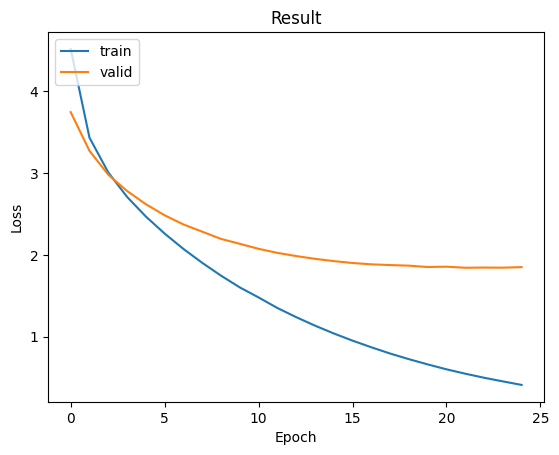

In [57]:
import torch.optim as optim
from trainer import Trainer

epochs = 30
optimizer_e= optim.AdamW(encoder.parameters(), lr=1e-4)
optimizer_d= optim.AdamW(decoder.parameters(), lr=1e-4)

trainer = Trainer(
    epochs=epochs, 
    train_loader=train_loader, 
    valid_loader=valid_loader, 
    model=model, 
    optimizer=[optimizer_e, optimizer_d],
    early_stopping=3
)
trainer.train()

In [11]:
model.load_state_dict(torch.load('model.ckpt'))
model.eval()

for idx in range(3):
    input_ids = src_tokenizer(x_valid[idx], max_length=256, truncation=True, padding="longest", return_tensors='pt').to(device).input_ids[:, 1:]
    generated_ids = model.generate(input_ids, max_len=20)
    print('\n輸入文字:', x_valid[idx])
    print('目標文字:', y_valid[idx])
    print('翻譯文字:', tgt_tokenizer.decode(generated_ids))


輸入文字: 他要愛。
目標文字: He wants affection.
翻譯文字: [CLS] he's love. [SEP]

輸入文字: 別再讓我做那事了。
目標文字: Don't make me do that again.
翻譯文字: [CLS] don't do that again. [SEP]

輸入文字: 我們愛湯姆。
目標文字: We love Tom.
翻譯文字: [CLS] we love tom. [SEP]
